Code to generate Figure 9 in 'Rethinking Discount Regularization'

# Imports

In [ ]:
import matplotlib.pyplot as plt
from pandas import DataFrame
import torch
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statistics import mean
import time
from google.colab import drive
import pickle

# Environment - River Swim


In [ ]:
def river_swim():
  """River swim environment

  from: https://papers.nips.cc/paper/2013/file/6a5889bb0190d0211a991f47bb19a777-Paper.pdf

  """
  R=np.array([[5./1000,0,0,0,0,0],[0,0,0,0,0,1]])
  #R += np.random.uniform(0,1,(2,6))*.01

  T_left = np.array([[1,0,0,0,0,0],[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0]])

  T_right = np.array([[0.4 , 0.6 , 0.  , 0.  , 0.  , 0.  ],
         [0.05, 0.6 , 0.35, 0.  , 0.  , 0.  ],
         [0.  , 0.05, 0.6 , 0.35, 0.  , 0.  ],
         [0.  , 0.  , 0.05, 0.6 , 0.35, 0.  ],
         [0.  , 0.  , 0.  , 0.05, 0.6 , 0.35],
         [0.  , 0.  , 0.  , 0.  , 0.4 , 0.6 ]])

  return np.array([T_left,T_right]),R

# Helper Functions

In [ ]:
def get_index (s,a):
  """helper fucntion to get (s,a) index
  """
  return s*num_actions+a

def greedy_policy(Q_sa,num_states,num_actions):
  """helper function to get greedy policy pi from Q_pi
  """

  Q_sa_unflattened = Q_sa.reshape(num_states,num_actions)
  pi = np.argmax(Q_sa_unflattened,axis=1)
  return pi

def pi_to_matrix(pi_actions):
  pi = np.zeros((num_states*num_actions,num_states))
  for s in range(num_states):
    sa = int(s*num_actions+pi_actions[s])
    pi[sa][s] = 1
  return pi

## Model-based

In [ ]:
#Estimate MDP
# default T if no data: uniform
# default R if no data: 0

def mle_estimate_T(count_matrix_list):

    num_states = count_matrix_list[0].shape[0]
    all_actions = range(len(count_matrix_list))

    #estimate transition matrix from data

    #assume equal probability to all states as default if no data
    default = (1./num_states)*np.ones(num_states)

    T_hat_list = []
    for a in all_actions:
        T_hat_list.append(np.zeros((num_states,num_states))) #transition matrix under action a

    for i in range(num_states):

        for act in all_actions:
            sum_act = count_matrix_list[act][i].sum(axis=1)

            if sum_act == 0: # never visited state i and took action "act"
                T_hat_list[act][i] = default
            else:
                T_hat_list[act][i] = (1./sum_act)*count_matrix_list[act][i]

    for a in all_actions:
        T_hat_list[a] = np.matrix(T_hat_list[a])

    return T_hat_list

In [ ]:
def uniform_prior(eps,sa_count_list):
    T_unif_list = []
    num_states = sa_count_list[0].shape[0]
    num_actions = len(sa_count_list)
    unif_prior = np.ones((num_states,num_states))

    total_sa_count = 0
    for sa_count in sa_count_list:
      total_sa_count += np.sum(sa_count)
    avg_count = total_sa_count/(num_states*num_actions)
    mag = eps/(1-eps)*avg_count/num_states

    for sa_count in sa_count_list:
        if eps == 1:
            alpha_post = 0*sa_count+unif_prior
        else:
            alpha_post = sa_count + mag*unif_prior

        T_post = np.zeros((num_states,num_states))
        default = (1./num_states)*np.ones(num_states) #uniform default, as above
        for i in range(num_states):
            sum_state = (alpha_post[i].sum(axis=1)).item()
            if sum_state == 0: # never visited state i and took action "act"
                T_post[i] = default
            else:
                T_post[i] = (1./sum_state)*alpha_post[i]
        T_unif_list.append(T_post)

    return T_unif_list

# Generate Data

In [ ]:
def gen_tuple(T_list,R_list,start_state_weights,action_weights):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    obs_rewards = [ [] for i in range(num_states)]

    actions = []

    all_states = range(num_states)
    state = np.random.choice(all_states,1,True,start_state_weights)[0]  # start at random state with uniform prob

    # choose random action
    action = np.random.choice(all_actions,p=action_weights)

    for a in all_actions:
      if action == a:
        t_probs = T_list[a][state].tolist()
    cum_tprobs = np.cumsum(t_probs)
    rand_num = np.random.uniform()
    for j in range(num_states):
      if rand_num < cum_tprobs[j]:
        next_state = j
        break

    reward = R_list[action][state].item()
    return (state,action,reward,next_state)


#gen dataset of tuples
def gen_data_tuples(num_tuples,T_list,R_list,start_state_weights,exact=False):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    act_weights = [1./num_actions for n in range(num_actions)]

    data_tuples = []

    if exact == False:

        for i in range(num_tuples):
            s,a,r,s_prime = gen_tuple(T_list,R_list,start_state_weights,act_weights)
            data_tuples.append((s,a,r,s_prime))

    else:
        start_state_nums = [int(u*num_tuples/num_actions) for u in start_state_weights]
        for state in range(num_states):

            start_state_weights_exact= np.zeros(num_states)
            start_state_weights_exact[state] = 1

            for a in range(num_actions):
                act_weights = np.zeros(len(T_list))
                act_weights[a] = 1

                for j in range(start_state_nums[state]):
                    s,a,r,s_prime = gen_tuple(T_list,R_list,start_state_weights_exact,act_weights)
                    data_tuples.append((s,a,r,s_prime))

    return data_tuples


In [ ]:
# sample data from MDP
#generate trajectories starting at S

def gen_trajectory(T_list,R_list,start_state_weights,action_weights,len_traj):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    all_states = range(num_states)
    state = np.random.choice(all_states,1,True,start_state_weights)[0]  # start at random state with uniform prob
    traj_current_len = 1

    data_tuples = []

    while traj_current_len < len_traj:

        # choose random action
        action = np.random.choice(all_actions,p=action_weights)

        for a in all_actions:
            if action == a:
                t_probs = T_list[a][state].tolist()
        cum_tprobs = np.cumsum(t_probs)
        rand_num = np.random.uniform()
        for j in range(num_states):
            if rand_num < cum_tprobs[j]:
                next_state = j
                break

        rew_stdev = .1*abs(R_list[action][state])
        obs_rew = np.random.normal(R_list[action][state],rew_stdev)

        data_tuples.append((state,action,obs_rew,next_state))
        state = next_state
        traj_current_len+=1

    return data_tuples


#gen dataset of trajectories
def gen_data_traj(num_traj,T_list,R_list,start_state_weights,len_traj):

    data_tuples = []

    #num_traj is number of trajectories in the data set TOTAL

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    r_counts = obs_rewards = [[ [] for i in range(num_states)] for a in range(num_actions)]

    act_weights = [1./num_actions for n in range(num_actions)]

    for i in range(num_traj):
        traj_tuples = gen_trajectory(T_list,R_list,start_state_weights,act_weights,len_traj)
        data_tuples.extend(traj_tuples)


    return data_tuples

In [ ]:
def tuples_to_count_array(tuple_data,num_states,num_actions):
  count_data = np.zeros((num_states*num_actions,num_states))
  for s,a,r,s_prime in tuple_data:
    sa_idx = get_index(s,a)
    count_data[sa_idx][s_prime] += 1

  return np.asarray(count_data)

In [ ]:
def tuples_to_sacountlist(data,num_states,num_actions):

  sa_count_list = []
  for a in range(num_actions):
        sa_count_list.append(np.zeros((num_states,num_states)))

  for (s,a,r,s_prime) in data:
    sa_count_list[a][s,s_prime]+=1

  for a in range(num_actions):
    sa_count_list[a] = np.matrix(sa_count_list[a])

  return sa_count_list

# Dynamic Programming

In [ ]:
def eval_policy(gamma,policy,T_list,R_list,theta):
  """Policy evaluation
  """

  num_states = T_list[0].shape[0]

  index = list(zip(policy,range(num_states)))
  T_pi = np.matrix([T_list[i][j] for (i,j) in index])
  #R_pi = np.transpose(np.matrix(R_list))
  R_pi = np.array([R_list[i][j] for (i,j) in index])

  value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,R_pi)

  return value

def value_iter(gamma, T_list,R_list, theta = .0001):
  """Value Iteration
  """

  num_states = T_list[0].shape[0]

  #T = torch.tensor(onp.array([onp.array(x) for x in T_list]))
  T = torch.tensor(np.array([np.array(x) for x in T_list]))
  #print('T',T)
  R = torch.tensor(np.array(R_list))

  #V = torch.tensor(np.zeros(10))
  V = torch.tensor(np.random.uniform(0,1,num_states))
  delta = 10.

  while delta > theta:
      v = V
      V = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).values
      delta= torch.max(torch.abs(v-V)).item()

  #get greedy policy
  P = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).indices

  #Get Q
  Q = R + gamma*torch.einsum("bij,j->bi", T, V)
  Q = np.array(Q).T

  return np.array(P),np.array(V),Q



In [ ]:
def FQI(gamma,num_iter,data,R_flattened,num_states,num_actions):
  """ https://ml.informatik.uni-freiburg.de/former/_media/publications/langegabelriedmiller2011chapter.pdf
      Section 4.2

  """
  R_sa_list = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      R_sa_list.append(str(s)+str(a))

  #Q_sa_list = [] #names of all sa pairs
  #for s in range(num_states):
  #  for a in range(num_actions):
  #    Q_sa_list.append(str(s)+str(a))

  # Initialize the Q table
  #Q_table = np.random.rand(num_states,num_actions).reshape(num_states,num_actions)
  Q_table = np.zeros((num_states,num_actions))
  Q_table_prev = np.ones((num_states,num_actions))
  #Q_flattened = Q_table.flatten()
  #Q_dict = dict([(key, value) for i, (key, value) in enumerate(zip(Q_sa_list, Q_flattened))])

  #initialize V(s_prime) randomly
  v_list = np.max(Q_table,axis=1)
  v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  data_df = pd.DataFrame(data,columns=['s','a','r','s_prime'])
  data_df['sa'] = data_df['s'].astype(str)+data_df['a'].astype(str)

  #if want to assume R known, use R_flattened instead of r column from data
  #otherwise comment out this block
  r_dict = dict([(key, value) for i, (key, value) in enumerate(zip(R_sa_list, R_flattened))])
  data_df['r'] = data_df['sa'].map(r_dict)

  Q_change = 100  #initialize
  Q_change_tol = 1e-10
  for i in range(num_iter):

    #if i%100==0:
    #  print('iter: ',i)
    #  print('Q_table',Q_table)

    #if (i>10) & (abs(Q_change) < Q_change_tol):
    #  print('i',i)
    #  print('breaking bc no change')
    #  break

    #Step 0 : update dataframe based on new Q, eps
    data_df['v_sprime'] = data_df['s_prime'].map(v_dict)

    #step 1: calc pattern set p
    data_df['p'] = data_df['r'] + gamma*data_df['v_sprime']

    # step 2: learn Q

    #create one-hot features
    P = data_df[['sa','p']]

    one_hot_P = pd.get_dummies(P,columns=['sa'])
    one_hot_features = one_hot_P.loc[:,~one_hot_P.columns.isin(['p'])]
    feature_names = one_hot_features.columns

    #learn regression
    model = LinearRegression(fit_intercept=False)
    model.fit(one_hot_features,one_hot_P['p'])
    coef_vals = dict(zip(feature_names,model.coef_))

    #update Q based on regression
    for s in range(num_states):
      for a in range(num_actions):
        ind = np.ravel_multi_index([a,s],(num_actions,num_states), order='C')
        try:
          key = 'sa_' + str(s) + str(a)
          Q_table[s][a] = coef_vals[key]
        except:
          Q_table[s][a]= R_flattened[ind] + gamma*np.mean(v_list)
    #print('Q_table',Q_table)
    diff = abs(Q_table_prev - Q_table)
    Q_change = diff.max()
    Q_table_prev = Q_table.copy()

    #update v_dict from new Q_table
    v_list = np.max(Q_table,axis=1)
    v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  p = np.argmax(Q_table,axis=1)
  v_list = np.array([max(i) for i in Q_table])

  return p,v_list,Q_table

# Model-based epsilon

In [ ]:
def epsilon_star_unif(T_sa,num_samples):
  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon if we knew true value of T

  """
  num_states = len(T_sa)
  numerator = 0
  denominator = 0
  for s_prime in range(num_states):
    numerator += (1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])
    denominator += ((1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime]) + T_sa[s_prime]**2 - 2/num_states*T_sa[s_prime] + 1/(num_states**2))
  return numerator/denominator

In [ ]:
def T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list):

  """State-specific regularization calculating epsilon* using true T

  (Theoretical minimum loss using our method)

  """
  num_states = T_list[0].shape[0]
  num_actions = len(T_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      num_sa_samples = num_samples_a[row_num][0]
      if num_sa_samples > 0:
        eps_sa = epsilon_star_unif(T_list[a].tolist()[row_num],num_sa_samples)
      else:
        eps_sa = 1

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.matrix(T_sa_reg))

  return T_sa_reg_list

# Model-free epsilon
$\mathcal{E}(Q_{\pi})$ from $\frac{\partial SSE}{\partial \mathcal{E}}$

In [ ]:
def get_epsilon1(Q,C,gamma,num_states,num_actions,R_flattened):
  #get greedy policy from Q
  pi = greedy_policy(Q,num_states,num_actions)
  pi_mat = pi_to_matrix(pi)

  #get constant k
  k= np.sum(pi_mat.T@Q)

  term1 = (gamma**2)*np.diag(C@(pi_mat.T@Q)**2)
  term2 = -((gamma**2)*k/num_states)*np.diag(C@pi_mat.T@Q)
  term3 = term2
  term4 = ((gamma**2)*(k**2)/(num_states**2))*np.diag(np.sum(C,axis=1))
  term4a = 1e-6*np.eye(num_states*num_actions) #for numerical stability

  #inv_term = np.linalg.inv(term1+term2+term3+term4+term4a)
  inv_term = np.linalg.solve(term1+term2+term3+term4+term4a,np.eye(num_states*num_actions))

  term5 = gamma*np.diag(R_flattened)@C@(pi_mat.T)@Q
  term6 = (gamma**2)*np.sum(np.diag(C@(pi_mat.T@Q)**2),axis=1)
  term7 = -gamma*np.diag(C@pi_mat.T@Q)@Q
  term8 = (-gamma*k/num_states)*np.diag(R_flattened)@C@np.ones(num_states)
  term9 = np.sum((-gamma**2*k/num_states)*np.diag(C@pi_mat.T@Q),axis=1)
  term10 = (gamma*k/num_states)*np.diag(np.sum(C,axis=1))@Q

  eps = inv_term@(term5+term6+term7+term8+term9+term10)
  eps = np.array([max(min(1,x),0) for x in eps])

  return eps

In [ ]:
def get_epsilon2(V,C,gamma,num_states,num_actions,T):

  """
  Testing bias-variance version

  Use true T in variance calc for now-- must fix this later.
  for now grid epsilon values. can take deriv and solve it it works?

  """
  epsilon = np.zeros((num_states,num_actions))   #store results here

  for state in range(num_states):
    for action in range(num_actions):

      idx = get_index(state,action)

      if np.sum(C[idx])==0:
        epsilon[state][action] = 1
      else:
        epsilon_grid =np.arange(0,1.01,.01)
        error={}
        for e in epsilon_grid:
          bias = gamma*e*(np.mean(V)-np.dot(T[action][state],V))

          variance = 0
          for s_n in range(num_states):
            variance += ((gamma*(1-e))**2)/np.sum(C[idx])*(V[s_n]**2)*T[action][state][s_n]*(1-T[action][state][s_n])
            #print('var1',variance)
            for s_nn in range(s_n+1,num_states): #covariance terms
              cov = (((gamma*(1-e))**2)/np.sum(C[idx]))*(-2)*V[s_n]*V[s_nn]*T[action][state][s_n]*T[action][state][s_nn]
              #print('cov',cov)
              variance += cov
          error[e] = bias**2 + variance

        epsilon[state][action] = min(error, key=error.get)

  return epsilon.flatten()

# Modified FQI

In [ ]:
def FQI_fixed_epstar(eps,gamma,num_iter,data,R_flattened,num_states,num_actions):
  """ https://ml.informatik.uni-freiburg.de/former/_media/publications/langegabelriedmiller2011chapter.pdf
      Section 4.2

  """

  R_sa_list = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      R_sa_list.append(str(s)+str(a))

  #Q_sa_list = [] #names of all sa pairs
  #for s in range(num_states):
  #  for a in range(num_actions):
  #   Q_sa_list.append(str(s)+str(a))

  # Initialize the Q table
  #Q_table = np.random.rand(num_states,num_actions).reshape(num_states,num_actions)  #onp.zeros((num_states,num_actions))
  Q_table = np.zeros((num_states,num_actions))
  Q_table_prev = np.ones((num_states,num_actions))
  #Q_flattened = Q_table.flatten()
  #Q_dict = dict([(key, value) for i, (key, value) in enumerate(zip(Q_sa_list, Q_flattened))])

  #initialize V(s_prime) randomly
  v_list = np.max(Q_table,axis=1)
  v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  data_df = pd.DataFrame(data,columns=['s','a','r','s_prime'])
  data_df['sa'] = data_df['s'].astype(str)+data_df['a'].astype(str)

  #if want to assume R known, use R_flattened instead of r column from data
  #otherwise comment out this block
  r_dict = dict([(key, value) for i, (key, value) in enumerate(zip(R_sa_list, R_flattened))])
  data_df['r'] = data_df['sa'].map(r_dict)


  Q_change = 100  #initialize
  Q_change_tol = 1e-10
  for i in range(num_iter):


    if (i>10) & (abs(Q_change) < Q_change_tol):
      print('i',i)
      print('breaking bc no change')
      break

    #Step 0 : update dataframe based on new Q, eps
    data_df['v_sprime'] = data_df['s_prime'].map(v_dict)

    #step 1: calc pattern set p
    data_df['p'] = data_df['r'] + gamma*((1-eps)*np.ones(len(data_df)))*data_df['v_sprime'] + gamma*eps*mean(v_dict.values())*np.ones(len(data_df))

    # step 2: learn Q

    #create one-hot features
    P = data_df[['sa','p']]

    one_hot_P = pd.get_dummies(P,columns=['sa'])
    one_hot_features = one_hot_P.loc[:,~one_hot_P.columns.isin(['p'])]
    feature_names = one_hot_features.columns

    #learn regression
    model = LinearRegression(fit_intercept=False)
    model.fit(one_hot_features,one_hot_P['p'])
    coef_vals = dict(zip(feature_names,model.coef_))

    #update Q based on regression
    for s in range(num_states):
      for a in range(num_actions):
        ind = np.ravel_multi_index([a,s],(num_actions,num_states), order='C')
        try:
          key = 'sa_' + str(s) + str(a)
          Q_table[s][a] = coef_vals[key]
        except:
          Q_table[s][a]= R_flattened[ind] + gamma*np.mean(v_list)
    diff = abs(Q_table_prev - Q_table)
    Q_change = diff.max()
    Q_table_prev = Q_table.copy()

    #update v_dict from new Q_table
    v_list = np.max(Q_table,axis=1)
    v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  p = np.argmax(Q_table,axis=1)
  v_list = np.array([max(i) for i in Q_table])

  return p,v_list,Q_table

In [ ]:
def FQI_reg_baseline1(gamma,num_iter,eps_update_freq,data,R_flattened,num_states,num_actions,true_Q,true_T,use_true_Q=False,reg=True):
  """ https://ml.informatik.uni-freiburg.de/former/_media/publications/langegabelriedmiller2011chapter.pdf
      Section 4.2

  """
  C = tuples_to_count_array(data,num_states,num_actions)

  v_true = true_Q.max(axis=1)

  sa_list_R = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      sa_list_R.append(str(s)+str(a))

  sa_list_Q = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      sa_list_Q.append(str(s)+str(a))

  # Initialize the Q table
  Q_table = np.zeros((num_states,num_actions))
  Q_table_prev = np.zeros((num_states,num_actions))
  Q_flattened = Q_table.flatten()
  Q_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list_Q, Q_flattened))])

  #initialize V(s_prime)
  v_list = np.max(Q_table,axis=1)
  v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  #learn static true epsilon
  Q_true_flattened = true_Q.flatten()  #for testing/comparison
  #print('v_true',v_true)

  #print('C',C)
  eps_flattened = get_epsilon1(Q_true_flattened,C,gamma,num_states,num_actions,R_flattened)
  #eps_flattened = np.zeros(num_states*num_actions) #TODO testing delete!

  eps = eps_flattened.reshape((num_states,num_actions))
  eps_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list_Q, eps_flattened))])

  #prepare data df
  data_df = pd.DataFrame(data,columns=['s','a','r','s_prime'])
  data_df['sa'] = data_df['s'].astype(str)+data_df['a'].astype(str)
  data_df['eps'] = data_df['sa'].map(eps_dict)

  #if want to assume R known, use R_flattened instead of r column from data
  #otherwise comment out this block
  r_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list_R, R_flattened))])
  data_df['r'] = data_df['sa'].map(r_dict)


  Q_change = 100  #initialize
  Q_change_tol = 1e-6
  for i in range(num_iter):
    #if i%100==0:
    #  print('iter',i)

    #if (i>10) & (abs(Q_change) < Q_change_tol):
      #print('i',i)
      #print('breaking bc no change')
      #break

    #Step 0 : update dataframe based on new Q, eps

    data_df['v_sprime'] = data_df['s_prime'].map(v_dict)

    #step 1: calc pattern set p
    data_df['p'] = data_df['r'] + gamma*(np.ones(len(data_df))-data_df['eps'])*data_df['v_sprime'] + gamma*data_df['eps']*mean(v_dict.values())


    # step 2: learn Q

    #create one-hot features
    P = data_df[['sa','p']]

    one_hot_P = pd.get_dummies(P,columns=['sa'])
    one_hot_features = one_hot_P.loc[:,~one_hot_P.columns.isin(['p'])]
    feature_names = one_hot_features.columns

    #learn regression
    model = LinearRegression(fit_intercept=False)
    model.fit(one_hot_features,one_hot_P['p'])
    coef_vals = dict(zip(feature_names,model.coef_))

    #update Q based on regression
    for s in range(num_states):
      for a in range(num_actions):
        try:
          key = 'sa_' + str(s) + str(a)
          Q_table[s][a] = coef_vals[key]
        except:
          Q_table[s][a]= 0

    diff = abs(Q_table_prev - Q_table)
    Q_change = diff.max()
    Q_table_prev = Q_table.copy()

    #update v_dict from new Q_table
    v_list = np.max(Q_table,axis=1)
    v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  p = np.argmax(Q_table,axis=1)
  v_list = np.array([max(i) for i in Q_table])

  return p,v_list,Q_table

In [ ]:
def FQI_reg_baseline2(gamma,num_iter,eps_update_freq,data,R_flattened,num_states,num_actions,true_Q,true_T,use_true_Q=False,reg=True):
  """ https://ml.informatik.uni-freiburg.de/former/_media/publications/langegabelriedmiller2011chapter.pdf
      Section 4.2

  """
  C = tuples_to_count_array(data,num_states,num_actions)
  v_true = true_Q.max(axis=1)

  sa_list_R = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      sa_list_R.append(str(s)+str(a))

  sa_list_Q = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      sa_list_Q.append(str(s)+str(a))

  # Initialize the Q table
  Q_table = np.zeros((num_states,num_actions))
  Q_table_prev = np.zeros((num_states,num_actions))
  Q_flattened = Q_table.flatten()
  Q_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list_Q, Q_flattened))])

  #initialize V(s_prime) randomly
  v_list = np.max(Q_table,axis=1)
  v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  #learn static true epsilon
  Q_true_flattened = true_Q.flatten()  #for testing/comparison
  #print('v_true',v_true)

  #print('C',C)
  eps_flattened = get_epsilon2(v_true,C,gamma,num_states,num_actions,true_T)
  #eps_flattened = np.zeros(num_states*num_actions) #TODO delete! testing
  eps = eps_flattened.reshape((num_states,num_actions))
  eps_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list_Q, eps_flattened))])

  #prepare data df
  data_df = pd.DataFrame(data,columns=['s','a','r','s_prime'])
  data_df['sa'] = data_df['s'].astype(str)+data_df['a'].astype(str)
  data_df['eps'] = data_df['sa'].map(eps_dict)

  #if want to assume R known, use R_flattened instead of r column from data
  #otherwise comment out this block
  r_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list_R, R_flattened))])
  data_df['r'] = data_df['sa'].map(r_dict)


  Q_change = 100  #initialize
  Q_change_tol = 1e-6
  for i in range(num_iter):

    #if i%100==0:
    #  print('iter: ',i)
      #print('eps',eps)
      #print('Q_table',Q_table)

    if (i>10) & (abs(Q_change) < Q_change_tol):
      #print('i',i)
      #print('breaking bc no change')
      break

    #Step 0 : update dataframe based on new Q, eps

    data_df['v_sprime'] = data_df['s_prime'].map(v_dict)

    #step 1: calc pattern set p
    data_df['p'] = data_df['r'] + gamma*(np.ones(len(data_df))-data_df['eps'])*data_df['v_sprime'] + gamma*data_df['eps']*mean(v_dict.values())

    # step 2: learn Q

    #create one-hot features
    P = data_df[['sa','p']]

    one_hot_P = pd.get_dummies(P,columns=['sa'])
    one_hot_features = one_hot_P.loc[:,~one_hot_P.columns.isin(['p'])]
    feature_names = one_hot_features.columns

    #learn regression
    model = LinearRegression(fit_intercept=False)
    model.fit(one_hot_features,one_hot_P['p'])
    coef_vals = dict(zip(feature_names,model.coef_))

    #update Q based on regression
    for s in range(num_states):
      for a in range(num_actions):
        try:
          key = 'sa_' + str(s) + str(a)
          Q_table[s][a] = coef_vals[key]
        except:
          Q_table[s][a]= 0
    diff = abs(Q_table_prev - Q_table)
    Q_change = diff.max()
    Q_table_prev = Q_table.copy()

    #update v_dict from new Q_table
    v_list = np.max(Q_table,axis=1)
    v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  p = np.argmax(Q_table,axis=1)
  v_list = np.array([max(i) for i in Q_table])

  return p,v_list,Q_table

# Compare model-based and Model-free

In [ ]:
def compare_loss(gamma,num_datasets,num_traj,len_traj,T_list,R_list,start_state_weights,use_true_Q=True):

  """ Recreate same loss curve as in ICML paper, curve across values of epsilon and horizontal line for state-action specific

      Do for both model-based and model-free together

  """

  #params
  theta = 0.001
  num_iter_fqi = 1000
  eps_update_freq=1000
  #epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]  #calc loss for range of values of epsilon
  epsilon_list = [0,.2,.4,.6,.8,.99]  #calc loss for range of values of epsilon

  num_states = T_list[0].shape[0]
  num_actions = len(T_list)
  R_flattened = R_list.T.flatten()  #this is true R

  p_true,v_true,q_true = value_iter(gamma, T_list,R_list, theta = theta)

  #comment out if loading from previous runs
  ss_loss_list_modelbased = []
  ss_loss_list_modelfree = []
  ss_loss_list_modelfree2 = []

  #store loss for each value of epsilon
  loss_dict_modelbased_disc = {} #discount regularization
  loss_dict_modelbased_unif = {} #uniform with fixed epsilon
  loss_dict_modelfree_disc = {} #discount regularization
  loss_dict_modelfree_eps = {} #uniform random updates with fixed epsilon
  for e in epsilon_list:
      loss_dict_modelbased_disc[e] = [] #discountf regularization
      loss_dict_modelbased_unif[e] = [] #uniform regularization
      loss_dict_modelfree_disc[e] = [] #discountf regularization
      loss_dict_modelfree_eps[e] = [] #uniform rnadom update regularization

  for d in range(num_datasets):

    if d%10==0:
      print('dataset ',d)

    data = gen_data_traj(num_traj,T_list,R_list,start_state_weights,len_traj)
    sa_count_list = tuples_to_sacountlist(data,num_states,num_actions)
    T_mle_list = mle_estimate_T(sa_count_list )

    #state-specific model-based oracle
    T_unif_ss_list = T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list)
    p_unif_ss_modelbased,v_unif_ss_modelbased,q_unif_ss_modelbased = value_iter(gamma,T_unif_ss_list,R_list)
    print('model based oracle policy',p_unif_ss_modelbased)
    v_unif_ss = eval_policy(gamma,p_unif_ss_modelbased,T_list,R_list,theta) #calculate value of policy in true MDP
    loss_unif_ss = v_true - v_unif_ss
    loss_unif_ss = np.average(loss_unif_ss,axis=None,weights=start_state_weights)
    ss_loss_list_modelbased.append(loss_unif_ss)

    #state-specific model-free oracles
    p_ss_modelfree,v_ss_modelfree,q_ss_modelfree = FQI_reg_baseline1(gamma,num_iter_fqi,eps_update_freq,data,R_flattened,num_states,num_actions,q_true,T_list,use_true_Q,reg=True)
    print('model-free oracle policy',p_ss_modelfree)
    v_reg_ss_modelfree = eval_policy(gamma,p_ss_modelfree,T_list,R_list,theta)
    loss_reg = v_true - v_reg_ss_modelfree
    loss_reg = np.average(loss_reg,axis=None,weights=start_state_weights)
    ss_loss_list_modelfree.append(float(loss_reg))

    p_ss_modelfree2,v_ss_modelfree2,q_ss_modelfree2 = FQI_reg_baseline2(gamma,num_iter_fqi,eps_update_freq,data,R_flattened,num_states,num_actions,q_true,T_list,use_true_Q,reg=True)
    print('model-free oracle policy 2',p_ss_modelfree2)
    v_reg_ss_modelfree2 = eval_policy(gamma,p_ss_modelfree2,T_list,R_list,theta)
    loss_reg = v_true - v_reg_ss_modelfree2
    loss_reg = np.average(loss_reg,axis=None,weights=start_state_weights)
    ss_loss_list_modelfree2.append(float(loss_reg))

    #fixed epsilon
    for e in epsilon_list:

      ## MODEL FREE

      #calc optimal policy for fixed eps regularized
      p_eps,v_eps,q_eps = FQI_fixed_epstar(e,gamma,num_iter_fqi,data,R_flattened,num_states,num_actions)

      #calc optimal policy for discount reg (these should be the same)
      p_disc,v_disc,q_disc = FQI((1-e)*gamma,num_iter_fqi,data,R_flattened,num_states,num_actions)

      #calculate value of policies above using true MDP
      v_eps_modelfree = eval_policy(gamma,p_eps,T_list,R_list,theta)
      v_disc_modelfree = eval_policy(gamma,p_disc,T_list,R_list,theta)

      #loss = expected value over starting state distrib
      loss_eps_modelfree = v_true - v_eps_modelfree
      loss_disc_modelfree = v_true - v_disc_modelfree

      loss_dict_modelfree_eps[e].append(np.average(loss_eps_modelfree,axis=None,weights=start_state_weights))
      loss_dict_modelfree_disc[e].append(np.average(loss_disc_modelfree,axis=None,weights=start_state_weights))

      ## MODEL BASED
      T_hat_unif = uniform_prior(e,sa_count_list)
      p_unif,v_unif,q_unif = value_iter(gamma,T_hat_unif,R_list,theta)
      p_disc,v_disc,q_disc = value_iter((1-e)*gamma,T_mle_list,R_list,theta)

      #calculate value of policies above using true MDP
      v_unif_modelbased = eval_policy(gamma,p_unif,T_list,R_list,theta)
      v_disc_modelbased = eval_policy(gamma,p_disc,T_list,R_list,theta)

      #loss = expected value over starting state distrib
      loss_unif_modelbased = v_true - v_unif_modelbased
      loss_disc_modelbased = v_true - v_disc_modelbased

      loss_dict_modelbased_unif[e].append(np.average(loss_unif_modelbased,axis=None,weights=start_state_weights))
      loss_dict_modelbased_disc[e].append(np.average(loss_disc_modelbased,axis=None,weights=start_state_weights))

  #save off data every x data sets

  #mean loss
  mean_loss_disc_modelfree = []
  mean_loss_eps_modelfree = []
  mean_loss_unif_modelbased = []
  mean_loss_disc_modelbased = []
  for e in epsilon_list:
      mean_loss_disc_modelfree.append(np.mean(loss_dict_modelfree_disc[e]))
      mean_loss_eps_modelfree.append(np.mean(loss_dict_modelfree_eps[e]))
      mean_loss_unif_modelbased.append(np.mean(loss_dict_modelbased_unif[e]))
      mean_loss_disc_modelbased.append(np.mean(loss_dict_modelbased_disc[e]))

  #mean state-specific
  mean_loss_ss_modelbased = np.mean(ss_loss_list_modelbased)
  mean_loss_ss_modelfree = np.mean(ss_loss_list_modelfree)
  mean_loss_ss_modelfree2 = np.mean(ss_loss_list_modelfree2)

  #stdev loss of MEAN loss
  stdev_loss_disc_modelfree = []
  stdev_loss_eps_modelfree = []
  stdev_loss_unif_modelbased = []
  stdev_loss_disc_modelbased = []
  for e in epsilon_list:
      stdev_loss_disc_modelfree.append(np.std(loss_dict_modelfree_disc[e])/np.sqrt(num_datasets))
      stdev_loss_eps_modelfree.append(np.std(loss_dict_modelfree_eps[e])/np.sqrt(num_datasets))
      stdev_loss_unif_modelbased.append(np.std(loss_dict_modelbased_unif[e])/np.sqrt(num_datasets))
      stdev_loss_disc_modelbased.append(np.std(loss_dict_modelbased_disc[e])/np.sqrt(num_datasets))

  #stdev state-specific
  stdev_loss_ss_modelbased = np.std(ss_loss_list_modelbased)/np.sqrt(num_datasets)
  stdev_loss_ss_modelfree = np.std(ss_loss_list_modelfree)/np.sqrt(num_datasets)
  stdev_loss_ss_modelfree2 = np.std(ss_loss_list_modelfree2)/np.sqrt(num_datasets)

  return mean_loss_disc_modelfree,mean_loss_eps_modelfree,mean_loss_unif_modelbased,mean_loss_disc_modelbased,\
    stdev_loss_disc_modelfree,stdev_loss_eps_modelfree,stdev_loss_unif_modelbased,stdev_loss_disc_modelbased, \
    mean_loss_ss_modelbased,mean_loss_ss_modelfree,mean_loss_ss_modelfree2,stdev_loss_ss_modelbased,stdev_loss_ss_modelfree,stdev_loss_ss_modelfree2

# River Swim Loss Comparison


In [ ]:
#using true V and true T in new bias/variance version of epsilon
#exploration by trajectory not tuples

T_list,R_list = river_swim()
num_states = T_list.shape[1]
num_actions = T_list.shape[0]
num_traj = 5
len_traj = 20
start_state_weights = (1./num_states)*np.ones(num_states)
gamma = 0.99
num_datasets = 10

mean_loss_disc_modelfree,mean_loss_eps_modelfree,mean_loss_unif_modelbased,mean_loss_disc_modelbased,\
    stdev_loss_disc_modelfree,stdev_loss_eps_modelfree,stdev_loss_unif_modelbased,stdev_loss_disc_modelbased, \
    mean_loss_ss_modelbased,mean_loss_ss_modelfree,mean_loss_ss_modelfree2,stdev_loss_ss_modelbased,stdev_loss_ss_modelfree,stdev_loss_ss_modelfree2 = \
    compare_loss(gamma,num_datasets,num_traj,len_traj,T_list,R_list,start_state_weights,use_true_Q=True)

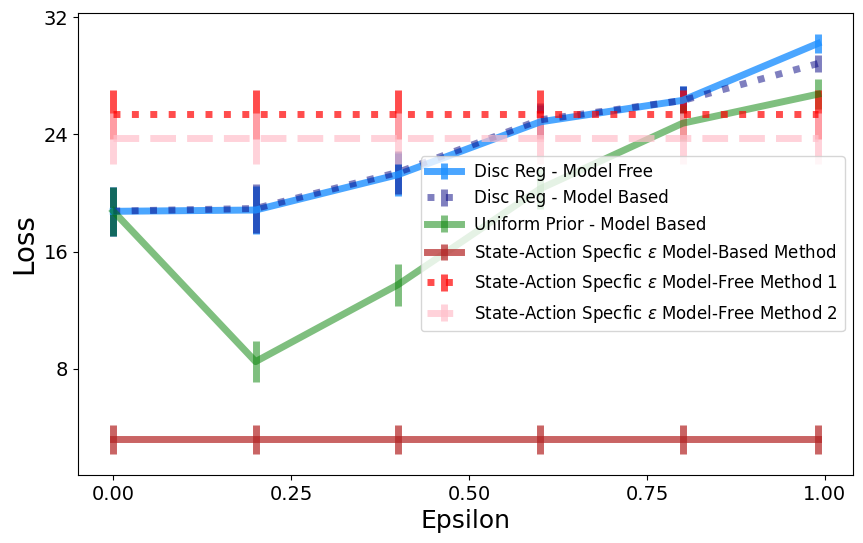

In [ ]:
epsilon_list = [0,.2,.4,.6,.8,.99]
fig,ax = plt.subplots(1,1,figsize=(10,6))

ax.errorbar(epsilon_list, mean_loss_disc_modelfree, yerr=[2*j for j in stdev_loss_disc_modelfree],label = 'Disc Reg - Model Free',alpha=.8,linewidth = 5.0,color='dodgerblue',linestyle='solid')
ax.errorbar(epsilon_list, mean_loss_disc_modelbased, yerr=[2*j for j in stdev_loss_disc_modelbased],label = 'Disc Reg - Model Based',alpha=.5,linewidth = 5.0,color='navy',linestyle='dotted')
ax.errorbar(epsilon_list, mean_loss_unif_modelbased, yerr=[2*j for j in stdev_loss_unif_modelbased],label = 'Uniform Prior - Model Based',alpha=.5,linewidth = 5.0,color='green')
ax.errorbar(epsilon_list,[mean_loss_ss_modelbased for i in epsilon_list],yerr=[2*stdev_loss_ss_modelbased for j in epsilon_list],color='firebrick',linewidth = 5.0,alpha = .7, label = r"State-Action Specfic $\epsilon$ Model-Based Method")
ax.errorbar(epsilon_list,[mean_loss_ss_modelfree for i in epsilon_list],yerr=[2*stdev_loss_ss_modelfree for j in epsilon_list],color='red',linewidth = 5.0,alpha = .7, linestyle='dotted', label = r"State-Action Specfic $\epsilon$ Model-Free Method 1")
ax.errorbar(epsilon_list,[mean_loss_ss_modelfree2 for i in epsilon_list],yerr=[2*stdev_loss_ss_modelfree2 for j in epsilon_list],color='pink',linewidth = 5.0,alpha = .7, linestyle='dashed', label = r"State-Action Specfic $\epsilon$ Model-Free Method 2")

ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Loss",fontsize=20)
ax.legend(fontsize=12,loc='center right')
plt.savefig('/content/gdrive/My Drive/RegularizationJournalPlots/riverswim_comparison_5trajlen20_oracle.pdf')